# Arxiv dataset EDA analysis - Abstract to Topic classification problem

## 1. Load the data (JSON file pre-downloaded from Kaggle)

In [34]:
import json

data_file = 'arxiv-metadata-oai-snapshot.json'

def get_metadata():
    with open(data_file, 'r') as f:
        for line in f:
            yield line

In [35]:
metadata = get_metadata()

In [36]:
all_data = []

for paper in metadata:
    all_data.append(json.loads(paper))

## Have a look at the data format

In [16]:
[{'abstract': a['abstract'], 'categories': a['categories']} for a in all_data[:3]]

[{'abstract': '  A fully differential calculation in perturbative quantum chromodynamics is\npresented for the production of massive photon pairs at hadron colliders. All\nnext-to-leading order perturbative contributions from quark-antiquark,\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\nall-orders resummation of initial-state gluon radiation valid at\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\nspecified in which the calculation is most reliable. Good agreement is\ndemonstrated with data from the Fermilab Tevatron, and predictions are made for\nmore detailed tests with CDF and DO data. Predictions are shown for\ndistributions of diphoton pairs produced at the energy of the Large Hadron\nCollider (LHC). Distributions of the diphoton pairs from the decay of a Higgs\nboson are contrasted with those produced from QCD processes at the LHC, showing\nthat enhanced sensitivity to the signal can be obtained with judicious\nselection 

## Plot count of articles per word count

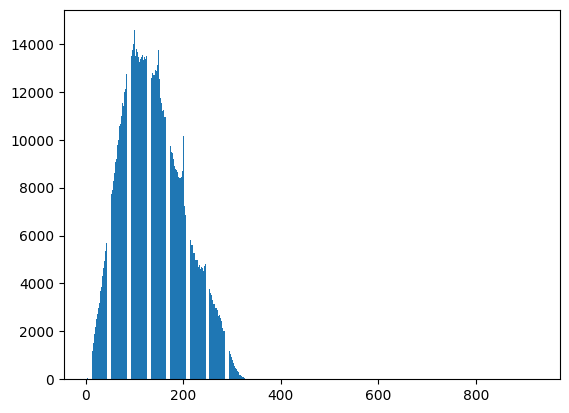

In [26]:
length_counts = Counter([len(text.split()) for text in all_abstracts])
plt.bar(*zip(*length_counts.items()))
plt.show()

## Plot count distribution of articles in time

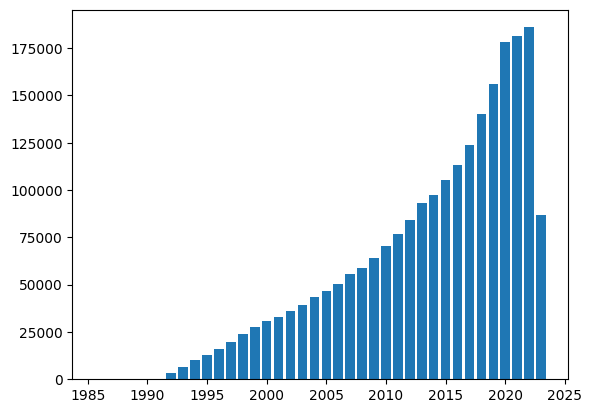

In [4]:
from datetime import datetime
from collections import Counter
import matplotlib.pyplot as plt

whole_dates = [datetime.strptime(a['versions'][0]['created'], '%a, %d %b %Y %H:%M:%S %Z') for a in all_data]
years = [d.year for d in whole_dates]
year_freqs = Counter(years)
plt.bar(*zip(*year_freqs.items()))
plt.show()

## Plot count distribution of all categories in dataset

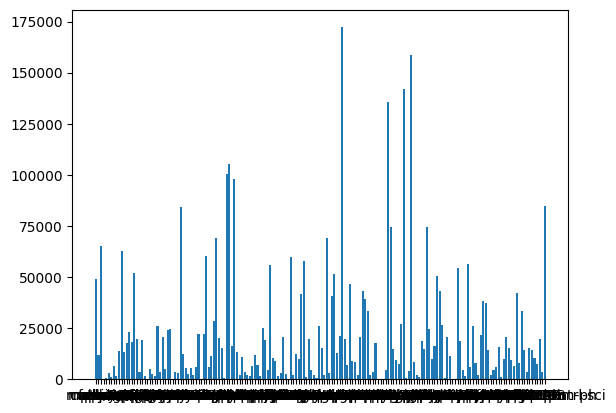

In [5]:
all_abstracts = [a['abstract'] for a in all_data]
all_categories = [cat for a in all_data for cat in a['categories'].split()]
category_counts = {cat: 0 for cat in list(set(all_categories))}
for a in all_data:
    for c in a['categories'].split():
        category_counts[c]+=1

plt.bar(*zip(*category_counts.items()))
plt.show()

## Have a look at category format

In [8]:
import random
random.choices(all_categories, k=10)

['quant-ph',
 'math.ST',
 'physics.optics',
 'cs.CV',
 'math.NA',
 'math.MP',
 'nucl-ex',
 'cs.LG',
 'math.DS',
 'cs.LG']

We can see that category format is the authentic arxiv category taxonomy format
`<general_category>.<subcategory>`
As our task is to classify abstracts to a subset of general category topics, we will need to extract all distinct general categories in the dataset and group them by topics, according to arxiv topic taxonomy.

### Let's see all general categories in the dataset

In [10]:
distinct_general_categories = list(set([d.split('.')[0] for d in list(set(all_categories))]))
distinct_general_categories

['econ',
 'physics',
 'hep-th',
 'funct-an',
 'comp-gas',
 'q-bio',
 'solv-int',
 'nucl-ex',
 'cmp-lg',
 'hep-ex',
 'gr-qc',
 'astro-ph',
 'hep-lat',
 'patt-sol',
 'chem-ph',
 'mtrl-th',
 'math',
 'adap-org',
 'dg-ga',
 'nucl-th',
 'chao-dyn',
 'stat',
 'hep-ph',
 'alg-geom',
 'eess',
 'cs',
 'q-alg',
 'q-fin',
 'bayes-an',
 'nlin',
 'acc-phys',
 'supr-con',
 'plasm-ph',
 'quant-ph',
 'math-ph',
 'cond-mat',
 'ao-sci',
 'atom-ph']

### As the articles are dating back to mid 1980s, some of the general categories are already archived and replaced with other names. So we have to prepare a manual category to topic mapping.

In [12]:
distinct_categories_map = {
    'nucl-ex': 'Physics',
    'cond-mat': 'Physics',
    'chem-ph': 'Physics',
     'dg-ga': 'Mathematics',
     'alg-geom': 'Mathematics',
     'mtrl-th': 'Physics',
     'gr-qc': 'Physics',
     'cs': 'Computer Science',
     'patt-sol': 'Physics',
     'acc-phys': 'Physics',
     'hep-ph': 'Physics',
     'econ': 'Economics',
     'hep-lat': 'Physics',
     'nucl-th': 'Physics',
     'solv-int': 'Physics',
     'adap-org': 'Physics',
     'bayes-an': 'Physics',
     'funct-an': 'Mathematics',
     'math-ph': 'Mathematics',
     'nlin': 'Physics',
     'eess': 'Electrical Engineering and Systems Science',
     'math': 'Mathematics',
     'cmp-lg': 'Computer Science',
     'chao-dyn': 'Physics',
     'stat': 'Statistics',
     'comp-gas': 'Physics',
     'plasm-ph': 'Physics',
     'hep-ex': 'Physics',
     'q-bio': 'Quantitative Biology',
     'hep-th': 'Physics',
     'astro-ph': 'Physics',
     'ao-sci': 'Physics',
     'quant-ph': 'Physics',
     'q-alg': 'Mathematics',
     'supr-con': 'Physics',
     'atom-ph': 'Physics',
     'physics': 'Physics',
     'q-fin': 'Quantitative Finance'
}

### Let's plot the distribution of articles per number of categories

Let's first see the boundaries of the category counts

In [20]:
category_counts = [len(a['categories'].split()) for a in all_data]
min_category_count = min(category_counts)
max_category_count = max(category_counts)
(min_category_count, max_category_count)

(1, 13)

As we can see, we have samples with up to 13 categories.

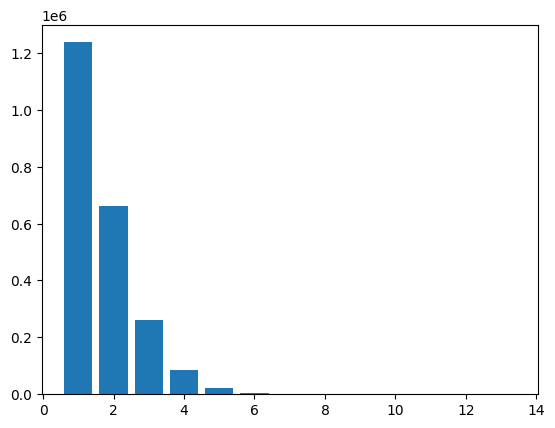

In [21]:
category_count_freqs = Counter(category_counts)
plt.bar(*zip(*category_count_freqs.items()))
plt.show()

In [22]:
category_count_freqs

Counter({1: 1236975,
         2: 662310,
         3: 260162,
         4: 84048,
         5: 23315,
         6: 4952,
         8: 138,
         7: 742,
         9: 31,
         10: 14,
         11: 2,
         13: 1})

As our problem is a topic classification, we would need to strip out the samples which have more than one topic as this will confuse the model and can lead to convergence.
For example if we have 3 categories, but all of them are a subset of one general topic, we can keep the sample. But if we have more than one general topic in the categories, we should strip out the sample from the dataset

### Let's plot the distribution of articles per single topic in the dataset

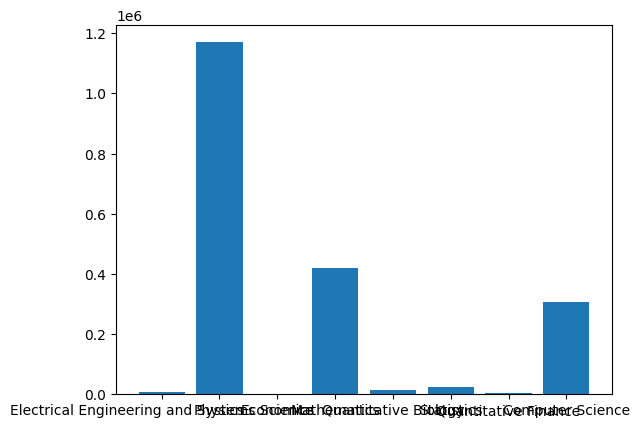

In [15]:
topics_map = {cat: 0 for cat in list(set(distinct_categories_map.values()))}

for a in all_data:
    topics = list(set([distinct_categories_map[c.split('.')[0]] for c in a['categories'].split()]))
    if len(topics) == 1:
        topics_map[topics[0]]+=1

plt.bar(*zip(*topics_map.items()))
plt.show()

In [14]:
topics_map

{'Electrical Engineering and Systems Science': 9161,
 'Physics': 1170032,
 'Economics': 1877,
 'Mathematics': 418834,
 'Quantitative Biology': 14384,
 'Statistics': 23620,
 'Quantitative Finance': 5769,
 'Computer Science': 308021}

As we can see, the data is quite imbalanced. We have 3 options for a trainset here:
1. Oversample the data with repetitions for the minor classes, to end up with evenly distributed oversampled large dataset
2. Undersample the data of the major classes, to end up with evenly distributed unique mid size dataset 
3. Use some of the multi category samples and assign them to the category with the lowest count

Having in mind that 'Economics' category is the lowest count with 1877 samples in 8-class label classification problem, such count of samples can be considered a good starting point for fine-tuning a BERT language model to such downstream task.
<br><br>
So we end up taking the decision 2.

# Part 2 - Dataset creation

In [37]:
import pandas as pd
all_data_df = pd.DataFrame(all_data)

In [38]:
del all_data
import gc
gc.collect()

0

In [ ]:
def getUniqueCategoriesForArticle(row):
    return list(set([distinct_categories_map[c.split('.')[0]] for c in row['categories'].split()]))

In [39]:
# Check if an article has only one unique general category
def isOneCategory(row):
    return len(getUniqueCategoriesForArticle(row)) == 1

Now get all rows with single category label and add a new coumn 'topic' that we will be training to predict

In [40]:
one_category_df = df.apply(isOneCategory, axis=1)
filtered_df = all_data_df[one_category_df]
filtered_df['topic'] = filtered_df.apply(
    lambda row: getUniqueCategoriesForArticle(row)[0], axis=1)

/var/folders/n2/2bg6c52s5h58t935bd8s5hdc0000gn/T/ipykernel_11900/2489173201.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['topic'] = filtered_df.apply(


Now create the final dataset df, sampling minority class count for each class.

In [42]:
dataset_df = pd.DataFrame()
for k in topics_map:
    dataset_df = pd.concat(
        [filtered_df[filtered_df['topic'] == k].sample(n=min(topics_map.values())), dataset_df], 
        sort=False, ignore_index=True)
    
dataset_df = dataset_df[['abstract', 'topic']]

Now split the dataframe in train+val and test parts and export them for future preprocessing and training usage

In [48]:
from sklearn.model_selection import train_test_split
import pandas as pd
import pickle
# from sklearn import preprocessing
# label_encoder = preprocessing.LabelEncoder()

# # train_df = pd.read_pickle('arxiv_trainset.pickle').reset_index(drop=True)
# dataset_df['topic_encoded'] = label_encoder.fit_transform(dataset_df['topic'])

X_train, X_test, y_train, y_test = train_test_split(dataset_df['abstract'].tolist(), 
                                                    dataset_df['topic'].tolist(), 
                                                    test_size=0.1, 
                                                    shuffle=True, 
                                                    random_state=42, 
                                                    stratify=dataset_df['topic'])

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.2, 
                                                  shuffle=True, 
                                                  random_state=42, 
                                                  stratify=y_train)

trainset_dict = {"X_train": X_train, "X_val": X_val, "y_train": y_train, "y_val": y_val}
testset_dict = {"X_test": X_test, "y_test": y_test}

with open('trainset.pickle', 'wb') as file:
    pickle.dump(trainset_dict, file)
    
with open('testset.pickle', 'wb') as file:
    pickle.dump(testset_dict, file)